In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_jsonl

pd.options.display.float_format = "{:.3f}".format

## The ELO results are organized as a 'tournament', computed by running elo.py

## The tournament standings and error estimates are contained in one file, and the match-by-match results in another

In [92]:
tournament = "tournaments/rakuda_koukou_v0_tournament"
standings = pd.DataFrame(load_jsonl(tournament + "_result.jsonl"))
standings.head()

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,Open Calm 7B,1043.754,240,1022.589,1048.482,1074.037,25.555,25.893
1,Open Calm 7B - Stormy,1029.838,240,999.853,1024.229,1048.794,24.564,24.377
2,Rinna 3.6B - PPO,1023.746,240,983.850,1007.896,1031.448,23.553,24.046
3,Rinna 3.6B,902.663,240,895.427,919.360,942.857,23.497,23.934


In [93]:
results = pd.DataFrame(load_jsonl(tournament + ".jsonl"))
results.head(1)

,bot1,bot2,prematch_elo1,prematch_elo2,question,question_id,response1,response2,referee_comments,score,postmatch_elo1,postmatch_elo2
0,Rinna 3.6B - PPO,Open Calm 7B - Stormy,1000.000,1000.000,消費税の引き上げが日本の経済に与えた影響を評価してください。具体的な経済指標を用いて説明して...,12,もちろんです。消費税の引き上げは、日本の景気後退を引き起こし、物価と賃金の低下をもたらしまし...,消費税は、日本の消費税と世界の他の国々との比較で議論されることが多いですが、ここでは特に言及...,アシスタント1の回答は、質問に対して具体的な経済指標を用いて回答しており、正確で詳細な説明が...,1,1006.900,993.100


## Elo scores evolve during the tournament, and along with the tournament results we compute 1-sigma error estimate

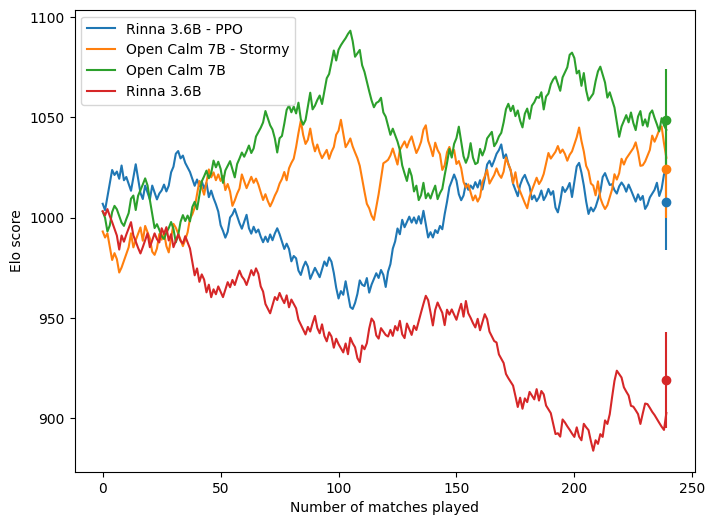

In [94]:
import matplotlib.pyplot as plt

elos = {}
for bot in results.bot1.unique():
    bot_elos = []
    for i, result in results.iterrows():
        if result["bot1"] == bot:
            bot_elos.append(result["postmatch_elo1"])
        elif result["bot2"] == bot:
            bot_elos.append(result["postmatch_elo2"])
        else:
            pass
    elos.update({bot: bot_elos})

fig, ax = plt.subplots(figsize=(8, 6))

standings = standings.set_index("model")
for k, v in elos.items():
    line = ax.plot(v, label=k)
    if k in standings.index:  # check if the model has bootstrap estimates
        # plt.errorbar(len(v) - 1, v[-1],
        #              yerr=[[bootstrap_elo.loc[k, 'error_y_minus']],
        #                    [bootstrap_elo.loc[k, 'error_y']]],
        #              fmt='o',color=line[0].get_color())
        ax.errorbar(
            len(v) - 1,
            standings.loc[k, "median"],
            yerr=[
                [standings.loc[k, "error_y_minus"]],
                [standings.loc[k, "error_y_plus"]],
            ],
            fmt="o",
            color=line[0].get_color()
        )
standings = standings.reset_index()
ax.set_xlabel("Number of matches played")
ax.set_ylabel("Elo score")
plt.legend(loc='upper left')

## The reviewer is biased towards the second model it sees,
## but our results are not because every model is equally likely to be shown first or second

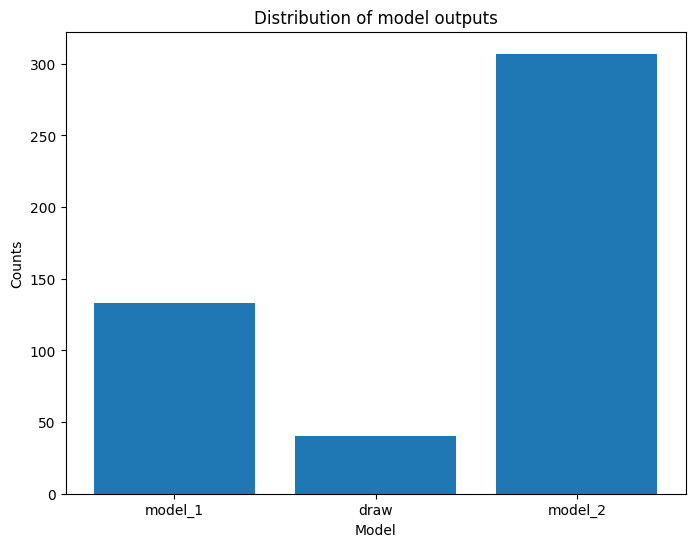

In [95]:
df = results["score"].value_counts()

# Order DataFrame by result
df = df.loc[[1, 3, 2]].reset_index()

# Define labels
labels = ["model_1", "draw", "model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"])
ax.set_xlabel("Model")
ax.set_ylabel("Counts")
ax.set_title("Distribution of model outputs")
plt.show()

## Detailed head-to-head results

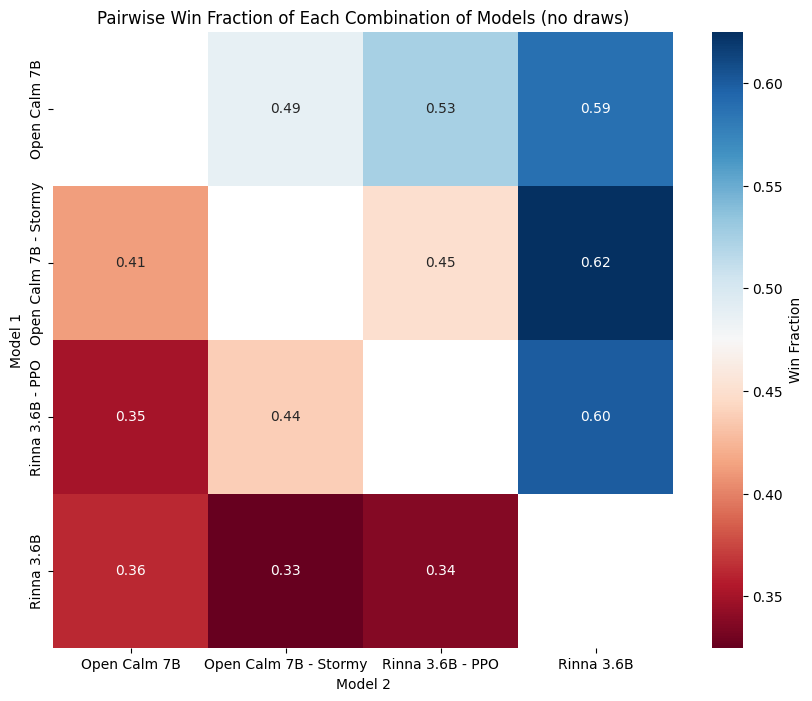

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def compute_pairwise_win_fraction(battles):
    all_models = list(set(battles["bot1"]).union(battles["bot2"]))
    empty_df = pd.DataFrame(0, index=all_models, columns=all_models)

    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 1],
        index="bot1",
        columns="bot2",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    a_win_ptbl = empty_df.add(a_win_ptbl, fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 2],
        index="bot1",
        columns="bot2",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    b_win_ptbl = empty_df.add(b_win_ptbl, fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(
        battles, index="bot1", columns="bot2", aggfunc="size", fill_value=0
    )

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (a_win_ptbl + b_win_ptbl.T) / (
        num_battles_ptbl + num_battles_ptbl.T
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col


def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(
        row_beats_col,
        annot=True,
        fmt=".2f",
        cmap="RdBu",
        cbar_kws={"label": "Win Fraction"},
    )
    ax.set_title(title)
    ax.set_xlabel("Model 2")
    ax.set_ylabel("Model 1")

    # plt.savefig("pairwise_win_fraction.png")
    plt.show()


visualize_pairwise_win_fraction(
    results, title="Pairwise Win Fraction of Each Combination of Models (no draws)"
)

## From the results list we can confirm recompute the elos to ensure the standings were computed correctly

In [97]:
from collections import defaultdict

## See elo.py for explanations for all these parameters

def compute_elo(battles, K=32, SCALE=400, BASE=10, INIT_RATING=1000, ETA=0):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, win in battles[["bot1", "bot2", "score"]].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE - ETA/np.log(BASE)))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE + ETA/np.log(BASE)))
        if win == 1:
            sa = 1
        elif win == 2:
            sa = 0
        elif win == 3:
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {win}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    rating = dict(sorted(rating.items(), key=lambda item: item[1], reverse=True))
    return rating

In [98]:
from elo import INITIAL_ELO, BASE, S, K, ETA 

assert all(
    [
        round(row["elo"], 6) == round(compute_elo(results, K, S, BASE, INITIAL_ELO, ETA)[row["model"]], 6)
        for i, row in standings.iterrows()
    ]
)

In [99]:
standings

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,Open Calm 7B,1043.754,240,1022.589,1048.482,1074.037,25.555,25.893
1,Open Calm 7B - Stormy,1029.838,240,999.853,1024.229,1048.794,24.564,24.377
2,Rinna 3.6B - PPO,1023.746,240,983.850,1007.896,1031.448,23.553,24.046
3,Rinna 3.6B,902.663,240,895.427,919.360,942.857,23.497,23.934


In [100]:
compute_elo(results, K, S, BASE, INITIAL_ELO, ETA)

{'Open Calm 7B': 1043.75378943162,
 'Open Calm 7B - Stormy': 1029.8378393362912,
 'Rinna 3.6B - PPO': 1023.745851047287,
 'Rinna 3.6B': 902.6625201848015}

# From elos we can predict model win rates

In [101]:
def predict_win_rate(standings, SCALE=400, BASE=10, ETA=0):
    names = sorted(list(standings["model"]))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (
                1
                + BASE
                ** (
                    (
                        standings.loc[standings["model"] == b, "elo"].values[0]
                        - standings.loc[standings["model"] == a, "elo"].values[0]
                    )
                    / SCALE
                    - ETA/ np.log(BASE)
                )
            )
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {a: [wins[a][b] if a != b else np.NAN for b in names] for a in names}

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

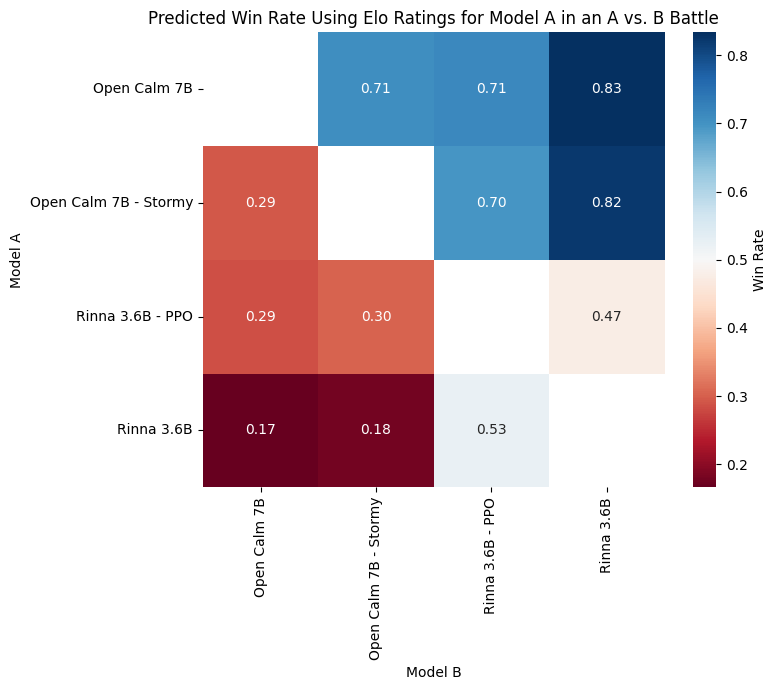

In [102]:
win_rate = predict_win_rate(standings, SCALE=S, BASE=BASE, ETA=ETA)

ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
ordered_win_rate = win_rate.loc[ordered_models, ordered_models]

fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(
    ordered_win_rate, annot=True, fmt=".2f", cmap="RdBu", cbar_kws={"label": "Win Rate"}
)
ax.set_title("Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle")
ax.set_xlabel("Model B")
ax.set_ylabel("Model A")
plt.tight_layout()
# plt.savefig('elo_predicted_win_rate.png')
plt.show()

### Check bootstrap confidence intervals were properly computed

Here we use bootstrap to estimate the confidence intervals

In [103]:
def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]


BOOTSTRAP_ROUNDS = 10000

bootstrap_elo_lu = get_bootstrap_result(results, lambda sample: compute_elo(sample, K, S, BASE, INITIAL_ELO, ETA), BOOTSTRAP_ROUNDS)
bootstrap_elo_lu

bootstrap: 100%|██████████| 10000/10000 [00:25<00:00, 385.83it/s]


,Open Calm 7B,Open Calm 7B - Stormy,Rinna 3.6B - PPO,Rinna 3.6B
0,1011.382,1047.928,1027.783,912.907
1,1064.323,1025.182,1011.037,899.458
2,1025.509,1025.451,1010.233,938.807
3,972.936,1095.414,1021.754,909.895
4,1009.748,1044.656,1016.015,929.580
...,...,...,...,...
9995,1045.596,1019.319,987.602,947.483
9996,1064.065,1008.460,1024.155,903.321
9997,1039.754,1001.956,1024.820,933.471
9998,1062.427,1039.095,964.925,933.553


In [104]:
bootstrap_elo = (
    pd.DataFrame(
        dict(
            #lower=bootstrap_elo_lu.quantile(0.025),
            lower=bootstrap_elo_lu.quantile(0.16),
            median=bootstrap_elo_lu.quantile(0.5),
            upper=bootstrap_elo_lu.quantile(0.84),
            #upper=bootstrap_elo_lu.quantile(0.975),
        )
    )
    .reset_index()
    .rename(columns={"index": "model"})
    .sort_values("median", ascending=False)
)
bootstrap_elo["error_y_plus"] = bootstrap_elo["upper"] - bootstrap_elo["median"]
bootstrap_elo["error_y_minus"] = bootstrap_elo["median"] - bootstrap_elo["lower"]

In [105]:
bootstrap_elo

,model,lower,median,upper,error_y_plus,error_y_minus
0,Open Calm 7B,1022.228,1048.341,1074.009,25.667,26.113
1,Open Calm 7B - Stormy,999.905,1024.415,1048.520,24.105,24.510
2,Rinna 3.6B - PPO,984.073,1007.834,1030.861,23.027,23.761
3,Rinna 3.6B,896.777,919.746,943.028,23.283,22.969


In [106]:
standings

,model,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,Open Calm 7B,1043.754,240,1022.589,1048.482,1074.037,25.555,25.893
1,Open Calm 7B - Stormy,1029.838,240,999.853,1024.229,1048.794,24.564,24.377
2,Rinna 3.6B - PPO,1023.746,240,983.850,1007.896,1031.448,23.553,24.046
3,Rinna 3.6B,902.663,240,895.427,919.360,942.857,23.497,23.934


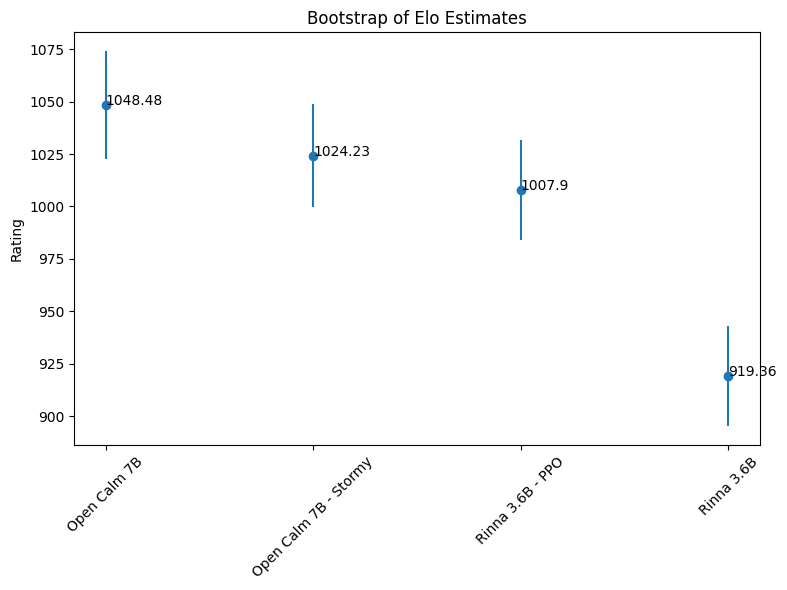

In [107]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    standings["model"],
    standings["median"],
    yerr=[standings["error_y_minus"], standings["error_y_plus"]],
    fmt="o",
)
for i, txt in enumerate(standings["median"]):
    ax.annotate(round(txt,2), (standings["model"][i], standings["median"][i]))
ax.set_title("Bootstrap of Elo Estimates")
ax.set_ylabel("Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plt.savefig('bootstrap_elo_estimates.png')
# plotly version
#
# fig = px.scatter(bootstrap_elo, x="model", y="median", error_y="error_y",
#                   error_y_minus="error_y_minus", text="median_rounded",
#                   title="Bootstrap of Elo Estimates")
# fig.update_layout(xaxis_title="Model", yaxis_title="Rating")
# fig.write_html("bootstrap_elo_estimates.html", full_html=False, include_plotlyjs="cdn")
# fig

# (Technical code follows. See https://arxiv.org/abs/2212.12015)

## To accelerate elo convergence with a biased reviewer, we calculate the home-field advantage parameter \eta

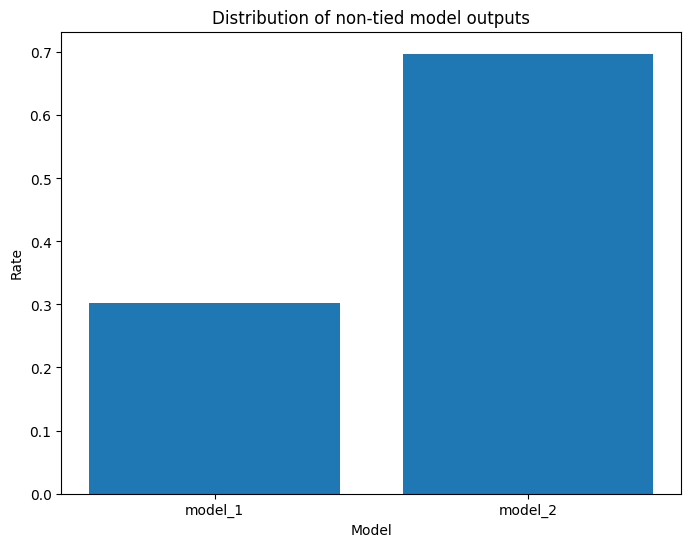

In [108]:
df = results.loc[results["score"]!=3, 'score'].value_counts()
df = df.loc[[1, 2]].reset_index()

# Define labels
labels = ["model_1","model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"]/(df["count"][0]+df["count"][1]))
ax.set_xlabel("Model")
ax.set_ylabel("Rate")
ax.set_title("Distribution of non-tied model outputs")
plt.show()

In [109]:
model1_winrate = df["count"][0]/(df["count"][0]+df["count"][1])
print(model1_winrate)

0.30227272727272725


In [110]:
#model1_winrate =  1/(1+BASE**(-IDEAL_ETA / np.log(BASE))
# log(BASE) * (-IDEAL_ETA / np.log(BASE) =  log(1/model1_winrate - 1)
IDEAL_ETA  = - np.log(1/model1_winrate-1)
print(IDEAL_ETA)

-0.8364986193654435


## Along with eta and the observed variance of model performances, calculate the optimal Beta parameter 
## (equivalently optimal point exchange parameter K)


In [111]:
## This analysis is only useful for s_exp=1
assert BASE == np.e and S == 1,'This formula only calculates the ideal beta if BASE was set to E and S to 1. The ideal beta is independent of BASE and S though'
v = standings['elo'].var() / 2
print(f"v: {v}")
eta = IDEAL_ETA
print(f"eta: {eta}")
M = len(standings)
print(f"M: {M}")
k = standings['num_matches'].sum()/2 / 4 # The 1/4 I am not sure why 2212.12015 put in. 
print(f"k: {k}")
hbar = 1/4 * np.sqrt(1/(v+1)) * np.exp(-eta**2/(4*(v+1)))
print(f"hbar: {hbar}")
hsquaredbar = 1/16 * np.sqrt(1/(2*v+1)) * np.exp(-eta**2/(2*(2*v+1)))
print(f"hsquaredbar: {hsquaredbar}")

ideal_beta = 1/2 * ((1-1/M) / (2*v) + hsquaredbar/hbar + 2* hsquaredbar*(k-1) / (M-1))**(-1)
print('Optimal Beta Parameter', ideal_beta)

AssertionError: This formula only calculates the ideal beta if BASE was set to E and S to 1. The ideal beta is independent of BASE and S though